## Import

In [1]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from simulation_and_control import pb, MotorCommands, PinWrapper, feedback_lin_ctrl, SinusoidalReference

pybullet build time: Sep  3 2024 12:59:12


## Configuration and preparation

In [2]:
# Configuration for the simulation
conf_file_name = "pandaconfig.json"  # Configuration file for the robot
cur_dir = os.getcwd()
sim = pb.SimInterface(conf_file_name, conf_file_path_ext=cur_dir)  # Initialize simulation interface

# Get active joint names from the simulation
ext_names = sim.getNameActiveJoints()
ext_names = np.expand_dims(np.array(ext_names), axis=0)  # Adjust the shape for compatibility

source_names = ["pybullet"]  # Define the source for dynamic modeling

# Create a dynamic model of the robot
dyn_model = PinWrapper(conf_file_name, "pybullet", ext_names, source_names, False, 0, cur_dir)
num_joints = dyn_model.getNumberofActuatedJoints()

# Print initial joint angles
print(f"Initial joint angles: {sim.GetInitMotorAngles()}")

# Sinusoidal reference
# Specify different amplitude values for each joint
amplitudes = [np.pi/4, np.pi/6, np.pi/4, np.pi/4, np.pi/4, np.pi/4, np.pi/4]  # Example amplitudes for joints
# Specify different frequency values for each joint
frequencies = [0.4, 0.5, 0.4, 0.4, 0.4, 0.4, 0.4]  # Example frequencies for joints

# Convert lists to NumPy arrays for easier manipulation in computations
amplitude = np.array(amplitudes)
frequency = np.array(frequencies)
ref = SinusoidalReference(amplitude, frequency, sim.GetInitMotorAngles())  # Initialize the reference
    
    
# Simulation parameters
time_step = sim.GetTimeStep()
current_time = 0
max_time = 12  # seconds
    
# Command and control loop
cmd = MotorCommands()  # Initialize command structure for motors
# PD controller gains
kp = 1000
kd = 100

# Initialize data storage
tau_mes_all = []
regressor_all = []

argv[0]=
file path ext:  /Users/typedef-mc_t/UCL_RAI/COMP0245_Robo_ML/lab_sessions_COMP0245_PUBLIC/week_1_2
Version = 4.1 Metal - 89.3
Vendor = Apple
Renderer = Apple M2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
Initial joint angles: [0.0, 1.0323, 0.0, 0.8247, 0.0, 1.57, 0.0]


2024-10-04 13:29:01.472 python[59394:2013261] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-04 13:29:01.472 python[59394:2013261] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


## Data collection loop

In [3]:
# Data collection loop
while current_time < max_time:
    # Measure current state
    q_mes = sim.GetMotorAngles(0)
    qd_mes = sim.GetMotorVelocities(0)
    qdd_mes = sim.ComputeMotorAccelerationTMinusOne(0)
        
    # Compute sinusoidal reference trajectory
    q_d, qd_d = ref.get_values(current_time)  # Desired position and velocity
        
    # Control command
    cmd.tau_cmd = feedback_lin_ctrl(dyn_model, q_mes, qd_mes, q_d, qd_d, kp, kd)
    sim.Step(cmd, "torque")

    # Get measured torque
    tau_mes = sim.GetMotorTorques(0)

    if dyn_model.visualizer: 
        for index in range(len(sim.bot)):  # Conditionally display the robot model
            q = sim.GetMotorAngles(index)
            dyn_model.DisplayModel(q)  # Update the display of the robot model

    # Exit logic with 'q' key
    keys = sim.GetPyBulletClient().getKeyboardEvents()
    qKey = ord('q')
    if qKey in keys and keys[qKey] and sim.GetPyBulletClient().KEY_WAS_TRIGGERED:
        break

        
    # Compute regressor and store it
    cur_regressor = dyn_model.ComputeDynamicRegressor(q_mes, qd_mes, qdd_mes)
    if current_time > 2:
        regressor_all.append(cur_regressor)
        tau_mes_all.append(tau_mes)
        
        
    current_time += time_step
    # Optional: print current time
    print(f"Current time in seconds: {current_time:.2f}")

Current time in seconds: 0.00
Current time in seconds: 0.00
Current time in seconds: 0.00
Current time in seconds: 0.00
Current time in seconds: 0.01
Current time in seconds: 0.01
Current time in seconds: 0.01
Current time in seconds: 0.01
Current time in seconds: 0.01
Current time in seconds: 0.01
Current time in seconds: 0.01
Current time in seconds: 0.01
Current time in seconds: 0.01
Current time in seconds: 0.01
Current time in seconds: 0.02
Current time in seconds: 0.02
Current time in seconds: 0.02
Current time in seconds: 0.02
Current time in seconds: 0.02
Current time in seconds: 0.02
Current time in seconds: 0.02
Current time in seconds: 0.02
Current time in seconds: 0.02
Current time in seconds: 0.02
Current time in seconds: 0.03
Current time in seconds: 0.03
Current time in seconds: 0.03
Current time in seconds: 0.03
Current time in seconds: 0.03
Current time in seconds: 0.03
Current time in seconds: 0.03
Current time in seconds: 0.03
Current time in seconds: 0.03
Current ti

## Parameters 'a'

In [4]:
# Stack all the regressors and all the torques, and compute the parameters 'a' using pseudoinverse
regressor_all = np.vstack(regressor_all)  # Shape (N*7, p(features))
print(f"Regressor shape: {regressor_all.shape}")
tau_mes_all = np.vstack(tau_mes_all)      # Shape (N, 7)
print(f"Torque measurements shape: {tau_mes_all.shape}")
tau_mes_all_flat = tau_mes_all.flatten()  # Shape (N*7,)
a = np.linalg.pinv(regressor_all) @ tau_mes_all_flat 
print(f"Parameters 'a' for the linear model:\n{a}")

Regressor shape: (70000, 70)
Torque measurements shape: (10000, 7)
Parameters 'a' for the linear model:
[ 6.01827174e-17 -9.90046139e-16 -4.15781073e-15  3.84245871e-15
  4.50876364e-15  6.31283102e-15  4.52023368e-15  3.51117365e-15
  6.31120745e-15  4.21814541e-01 -9.18882953e-15 -2.68705061e-01
 -1.13684630e+00  3.47040416e-15  2.43604848e-01  2.30442841e-04
  1.78209693e-01  3.07194845e-05  1.17959831e-04  6.46787175e-02
  3.90027396e-01  4.38264521e-01  1.30373338e-04  1.33168152e+00
  1.49580629e-01  3.95183385e-05  1.58702937e-01 -3.10081374e-05
  3.60311812e-05  3.63424056e-01  4.29737945e-01 -2.73354542e-01
  4.48477576e-01 -1.27113075e-04  2.17564932e-01  3.67547230e-02
  2.95439752e-01 -1.82449650e-06 -4.08148094e-04  2.67474871e-01
  7.01022841e-01 -1.14237341e-04 -9.87026672e-05  8.24020410e-01
  2.74319994e-01  1.75137391e-04  2.10719810e-01  2.01509601e-04
 -3.57578641e-04  3.63219218e-01  7.01022841e-01 -2.22396237e-02
 -8.08514564e-05  9.87026672e-05  4.02930978e-01 -6

## MSE

In [5]:
# Compute the metrics for the linear model
tau_pred_all_flat = regressor_all @ a     # Shape (N*7,)
mse = np.mean((tau_mes_all_flat - tau_pred_all_flat)**2)
print(f"MSE for the linear model:{mse}")

MSE for the linear model:0.0013630793539406501


## R^2

In [6]:
# Compute the adjusted R-squared value
tss = np.sum((tau_mes_all_flat - np.mean(tau_mes_all_flat))**2)
rss = np.sum((tau_mes_all_flat - tau_pred_all_flat)**2)
r_squared = 1 - rss/tss
print(f"R-squared for the linear model: {r_squared}")

R-squared for the linear model: 0.9999972414168372


## F-statistic

In [7]:
# Compute the F-statistic
n = tau_mes_all_flat.shape[0]
print(f"Number of samples: {n}")
p = a.shape[0]
f_stat = (tss - rss)/(rss/(n-p-1))
print(f"F-statistic for the linear model: {f_stat}")

Number of samples: 70000
F-statistic for the linear model: 25349537413.828655


## Confidence Interval for parameters

In [8]:
# Compute the confidence intervals for the parameters and for the prediction
# Estimate variance of the residuals
sigma_squared = rss / (n - p)
    
# Compute the covariance matrix of the parameter estimates
XTX_inv = np.linalg.pinv(regressor_all.T @ regressor_all)
param_var = sigma_squared * XTX_inv  # Covariance matrix of parameters
param_se = np.sqrt(np.abs(np.diag(param_var)))  # Standard errors of parameters

# Compute confidence intervals for parameters
lower_bounds = a - 2 * param_se
upper_bounds = a + 2 * param_se
    
# Display confidence intervals
for i in range(len(a)):
    print(f"Parameter {i+1}: Estimate = {a[i]:.4f}, 95% CI = [{lower_bounds[i]:.4f}, {upper_bounds[i]:.4f}]")

Parameter 1: Estimate = 0.0000, 95% CI = [0.0000, 0.0000]
Parameter 2: Estimate = -0.0000, 95% CI = [-0.0000, -0.0000]
Parameter 3: Estimate = -0.0000, 95% CI = [-0.0000, -0.0000]
Parameter 4: Estimate = 0.0000, 95% CI = [0.0000, 0.0000]
Parameter 5: Estimate = 0.0000, 95% CI = [0.0000, 0.0000]
Parameter 6: Estimate = 0.0000, 95% CI = [0.0000, 0.0000]
Parameter 7: Estimate = 0.0000, 95% CI = [0.0000, 0.0000]
Parameter 8: Estimate = 0.0000, 95% CI = [0.0000, 0.0000]
Parameter 9: Estimate = 0.0000, 95% CI = [0.0000, 0.0000]
Parameter 10: Estimate = 0.4218, 95% CI = [0.4203, 0.4234]
Parameter 11: Estimate = -0.0000, 95% CI = [-0.0000, 0.0000]
Parameter 12: Estimate = -0.2687, 95% CI = [-0.2838, -0.2536]
Parameter 13: Estimate = -1.1368, 95% CI = [-1.1435, -1.1301]
Parameter 14: Estimate = 0.0000, 95% CI = [-0.0000, 0.0000]
Parameter 15: Estimate = 0.2436, 95% CI = [0.2406, 0.2466]
Parameter 16: Estimate = 0.0002, 95% CI = [-0.0002, 0.0007]
Parameter 17: Estimate = 0.1782, 95% CI = [0.1766

## Torque prediction error for each joint

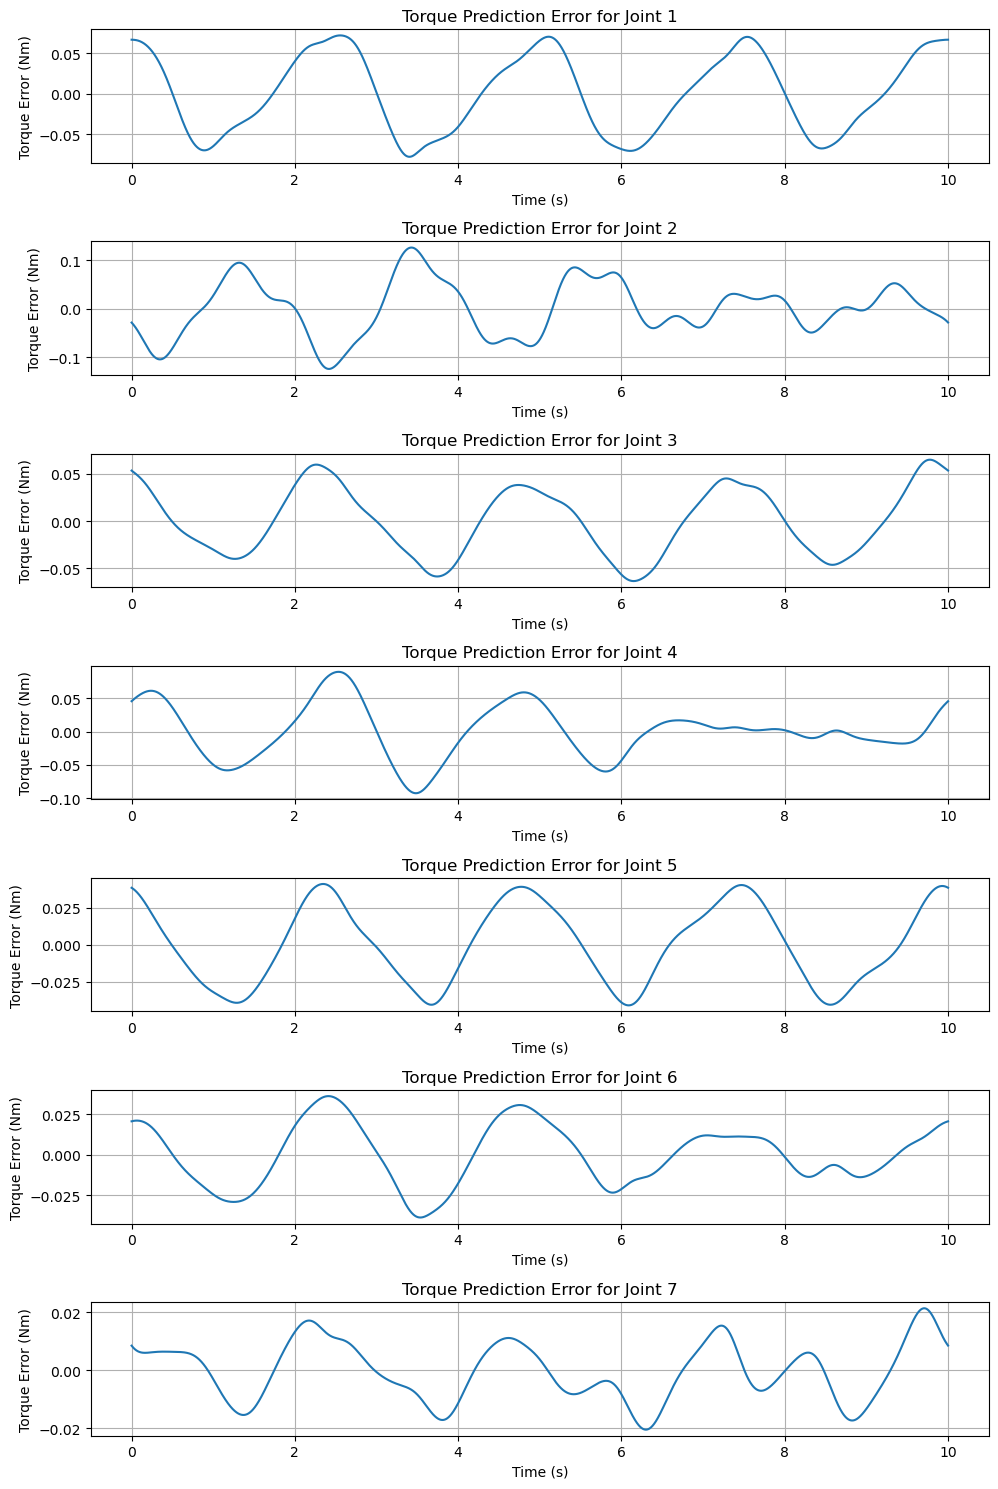

: 

In [9]:
# Plot the torque prediction error for each joint
tau_pred_all = tau_pred_all_flat.reshape(-1, num_joints)  # Shape (N, 7)
# Reshape tau_pred_all_flat to match tau_mes_all shape
# Compute the error
error_all = tau_mes_all - tau_pred_all  # Shape (N, 7)
# Create time vector
N = tau_mes_all.shape[0]
t = np.linspace(0, N * time_step, N)
# Plot the error for each joint
_, axs = plt.subplots(num_joints, 1, figsize=(10, 15))
for i in range(num_joints):
    axs[i].plot(t, error_all[:, i])
    axs[i].set_title(f'Torque Prediction Error for Joint {i+1}')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Torque Error (Nm)')
    axs[i].grid(True)
plt.tight_layout()
plt.show()